In [2]:
from tqdm import tqdm, trange
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances
from sklearn.decomposition import PCA
import umap.umap_ as umap


import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset

import clip
from diffusers import StableDiffusionInstructPix2PixPipeline

from attacker_network import AttackerNetwork
from learnable_prompt import LearnablePrompt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

/users/eleves-b/2024/mattia.martino/env_cv/lib64/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225]),
])

dataset = datasets.ImageFolder(root='dogs_data/Images/', transform=transform)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

In [4]:
dino = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')
dino.to(device)
dino.eval()
for p in dino.parameters():
    p.requires_grad = False


clip_model = clip.load("ViT-L/14", device=device)[0]
clip_model.eval()


pix2pix = StableDiffusionInstructPix2PixPipeline.from_pretrained(
    "timbrooks/instruct-pix2pix",
    torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
    safety_checker=None,
).to(device)

Using cache found in /users/eleves-b/2024/mattia.martino/.cache/torch/hub/facebookresearch_dino_main
Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.86it/s]


In [5]:
def compute_centroids(model):
    features = []
    labels = []

    for images, label in tqdm(dataloader):
        images = images.to(device)
        with torch.no_grad():
            feature = model(images).cpu().numpy()
        features.append(feature)
        labels.extend(label.cpu().numpy())
    
    features = np.concatenate(features, axis=0)
    labels = np.array(labels)

    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)

    centroids = np.zeros((n_classes, features.shape[1]))
    for i, c in enumerate(unique_classes):
        class_indices = np.where(labels == c)[0]
        centroids[i] = np.mean(features[class_indices], axis=0)

    os.makedirs("variables", exist_ok=True)
    np.save('variables/centroids.npy', centroids)
    np.save('variables/features.npy', features)
    np.save('variables/labels.npy', labels)

    return centroids, features, labels

In [6]:
# centroids, features, labels = compute_centroids(dino)

centroids = np.load('variables/centroids.npy')
features = np.load('variables/features.npy')
labels = np.load('variables/labels.npy')

In [7]:
np.random.seed(0)

unique_classes = np.unique(labels)
n_classes = len(unique_classes)

class_id_to_name = {v: k for k, v in dataset.class_to_idx.items()}
class_names = [class_id_to_name[cls] for cls in unique_classes]

random_classes = np.random.choice(unique_classes, size=2, replace=False)
starting_class = random_classes[0]
starting_class_name = class_id_to_name[starting_class].split('-')[-1]
target_class = random_classes[1]
target_class_name = class_id_to_name[target_class].split('-')[-1]

classes = {starting_class: starting_class_name + " (starting)", target_class: target_class_name + " (target)"}

print(f"Starting class: {starting_class_name} ({starting_class})")
print(f"Target class: {target_class_name} ({target_class})")

Starting class: Irish_terrier (33)
Target class: basset (10)


/users/eleves-b/2024/mattia.martino/env_cv/lib64/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


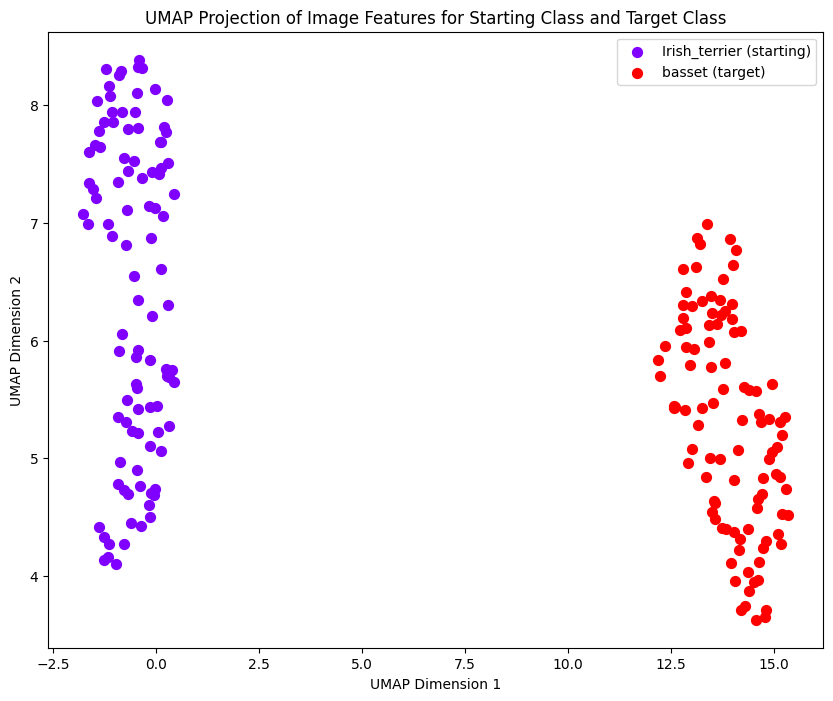

In [8]:
np.random.seed(0)

subset_size = 100

starting_features = []
target_features = []
for c in random_classes:
    class_indices = np.where(labels == c)[0]
    sampled_indices = np.random.choice(class_indices, size=subset_size, replace=False)
    if c == starting_class:
        starting_features.append(features[sampled_indices])
    else:
        target_features.append(features[sampled_indices])

starting_features = np.concatenate(starting_features, axis=0)
target_features = np.concatenate(target_features, axis=0)

starting_labels = np.full((starting_features.shape[0],), starting_class)
target_labels = np.full((target_features.shape[0],), target_class)

plotting_features = np.concatenate([starting_features, target_features], axis=0)
plotting_labels = np.concatenate([starting_labels, target_labels], axis=0)

umap_reducer = umap.UMAP(n_components=2, random_state=0)
embedding = umap_reducer.fit_transform(plotting_features)

colors = cm.rainbow(np.linspace(0, 1, len(random_classes)))

plt.figure(figsize=(10, 8))
# Plot features for each selected class with a distinct color
for i, cls in enumerate(random_classes):
    cls_mask = (plotting_labels == cls)
    plt.scatter(
        embedding[cls_mask, 0],
        embedding[cls_mask, 1],
        s=50,
        color=colors[i],
        label=classes[cls]
    )

plt.title("UMAP Projection of Image Features for Starting Class and Target Class")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend()
plt.show()

In [9]:
starting_centroid = centroids[starting_class]
target_centroid = centroids[target_class]

# Compute the distance between the centroids
distance = euclidean_distances(starting_centroid.reshape(1, -1), target_centroid.reshape(1, -1))[0][0]
print(f"Distance between centroids: {distance:.2f}")

distances = euclidean_distances(centroids)
average_distance = distances.mean()
print(f"Average distance between centroids: {average_distance:.2f}")

min_distance = distances[~np.eye(distances.shape[0], dtype=bool)].min()
print(f"Minimum distance between centroids: {min_distance:.2f}")

max_distance = distances[~np.eye(distances.shape[0], dtype=bool)].max()
print(f"Maximum distance between centroids: {max_distance:.2f}")

Distance between centroids: 89.85
Average distance between centroids: 79.03
Minimum distance between centroids: 15.67
Maximum distance between centroids: 110.05


In [10]:
# target_indices = [i for i, (_, label) in enumerate(dataset) if label in random_classes]
target_indices = np.load('variables/target_indices.npy')
breed_subset = Subset(dataset, target_indices)

pil_to_tensor = transforms.ToTensor() 

In [11]:
np.random.seed(0)

attacker = attacker = AttackerNetwork(
    device=device,
)

n_epochs = 100

optimizer = torch.optim.Adam(attacker.parameters(), lr=1e-3)

target_centroid = torch.tensor(target_centroid).to(device)
starting_centroid = torch.tensor(starting_centroid).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00,  6.31it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
positive_prompt = LearnablePrompt(
            device=device,
            clip_model=clip_model,
            template= "Make the image: ",
            ctx_len=10
        )

negative_prompt = LearnablePrompt(
            device=device,
            clip_model=clip_model,
            template="bad quality, blurry, low resolution",
            ctx_len=10
        )

In [13]:
image = breed_subset[0][0].to(device)


output = pix2pix(
            prompt_embeds=positive_prompt(),
            negative_prompt_embeds=negative_prompt(),
            image=image,
            num_inference_steps=50,
            guidance_scale=7.5,
            output_type="pt",  # Return tensor instead of PIL image
        )

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 0 has a total capacity of 23.55 GiB of which 1.75 MiB is free. Process 255625 has 5.35 GiB memory in use. Including non-PyTorch memory, this process has 18.05 GiB memory in use. Of the allocated memory 17.34 GiB is allocated by PyTorch, and 415.05 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
output.requires_grad

In [ ]:
dist_target = torch.norm(output_features - target_centroid, p=2, dim=1)
dist_starting = torch.norm(output_features - starting_centroid, p=2, dim=1)


In [ ]:
attacker.train()
for epoch in trange(n_epochs):

    for image, _ in tqdm(breed_subset, desc=f"Epoch {epoch+1}/{n_epochs}", total=len(breed_subset), leave=False):
        image = image.to(device)

        output_features, _, _ = attacker(image)
        dist_target = torch.norm(output_features - target_centroid, p=2, dim=1)
        dist_starting = torch.norm(output_features - starting_centroid, p=2, dim=1)

        loss = (dist_target - dist_starting).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % (n_epochs/5) == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")

os.makedirs("models", exist_ok=True)
torch.save(attacker.state_dict(), "attacker.pth")
        

In [ ]:
np.random.seed(0)

attacker = attacker = AttackerNetwork(
    device=device,
)

n_epochs = 100

optimizer = torch.optim.Adam(attacker.parameters(), lr=1e-3)

target_centroid = torch.tensor(target_centroid).to(device)
starting_centroid = torch.tensor(starting_centroid).to(device)


attacker.train()
for epoch in trange(n_epochs):

    for image, labels in tqdm(breed_subset, desc=f"Epoch {epoch+1}/{n_epochs}", total=len(breed_subset), leave=False):
        image = image.to(device)

        output, _, _ = attacker(image)
        print(f"Output shape: {output.shape}")
        output_features = dino(output)
        dist_target = torch.norm(output_features - target_centroid, p=2, dim=1)
        dist_starting = torch.norm(output_features - starting_centroid, p=2, dim=1)

        loss = (dist_target - dist_starting).mean()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch + 1) % (n_epochs/5) == 0:
        print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {loss.item():.4f}")

os.makedirs("models", exist_ok=True)
torch.save(attacker.state_dict(), "attacker.pth")
        